In [1]:
%load_ext zipline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials

In [2]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

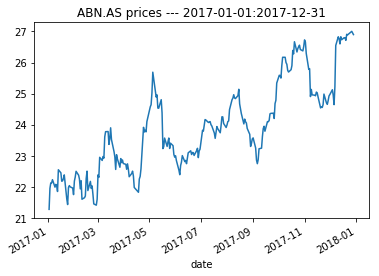

In [3]:
download_csv_data(ticker='ABN.AS', 
                  start_date='2017-01-01', 
                  end_date='2017-12-31', 
                  freq='daily', 
                  path='C:/Users/Sela#/Documents/Jupyter Projects/Data/abn.txt')

In [4]:
!head 'C:/Users/Sela#/Documents/Jupyter Projects/Data/abn.csv'

'head' is not recognized as an internal or external command,
operable program or batch file.


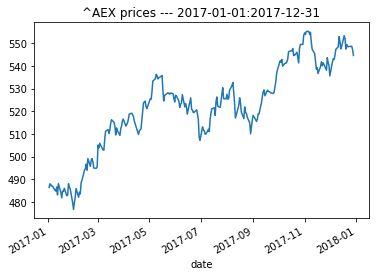

In [5]:
download_csv_data(ticker='^AEX', 
                  start_date='2017-01-01', 
                  end_date='2017-12-31', 
                  freq='daily', 
                  path='C:/Users/Sela#/Documents/Jupyter Projects/Data/aex.csv')

In [6]:
import os
from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [7]:
from zipline.data import bundles

bundle = bundles.load('eu_stocks')
bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)

ValueError: SQLite file 'C:\\Users\\Sela#/.zipline\\data\\eu_stocks\\2019-11-21T18;06;08.010583\\assets-6.sqlite' doesn't exist.

In [ ]:
%%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o buy_and_hold.pkl --trading-calendar XAMS



# imports
from zipline.api import order, symbol, record, set_benchmark

# parameters
selected_stock = 'ABN'
n_stocks_to_buy = 10

def initialize(context):
    set_benchmark(symbol('AEX'))
    context.asset = symbol('ABN')
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True

In [ ]:
# read the performance summary dataframe
buy_and_hold_results = pd.read_pickle('buy_and_hold.pkl')

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

# portfolio value
buy_and_hold_results.portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('portfolio value in €')

# asset
buy_and_hold_results.price.plot(ax=ax[1])
ax[1].set_ylabel('price in €')

# mark transactions
perf_trans = buy_and_hold_results.loc[[t != [] for t in buy_and_hold_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax[1].plot(buys.index, buy_and_hold_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax[1].plot(sells.index, buy_and_hold_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

# daily returns
buy_and_hold_results.returns.plot(ax=ax[2])
ax[2].set_ylabel('daily returns')

fig.suptitle('Buy and Hold Strategy - ABN AMRO', fontsize=16)
plt.legend()
plt.show()

print('Final portfolio value (including cash): {}€'.format(np.round(buy_and_hold_results.portfolio_value[-1], 2)))

In [ ]:
pd.DataFrame.from_records([x[0] for x in buy_and_hold_results.transactions.values if x != []])

In [ ]:
buy_and_hold_results.columns

In [ ]:
%%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o sma_strategy.pkl --trading-calendar XAMS

# imports 
from zipline.api import order_target, record, symbol, set_benchmark
from zipline.finance import commission
import matplotlib.pyplot as plt
import numpy as np

# parameters 
ma_periods = 20
selected_stock = 'ABN'
n_stocks_to_buy = 10

def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    set_benchmark(symbol('AEX'))
    # 1. manually setting the commission
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    # 2. warm-up period
    context.time += 1
    if context.time < ma_periods:
        return

    # 3. access price history
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
 
    # 4. calculate moving averages
    ma = price_history.mean()
    
    # 5. trading logic
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           moving_average=ma)
    
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    perf.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in €')
    
    # asset
    perf[['price', 'moving_average']].plot(ax=ax[1])
    ax[1].set_ylabel('price in €')
    
    # mark transactions
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()
    
    # daily returns
    perf.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle('Simple Moving Average Strategy - ABN AMRO', fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}€'.format(np.round(perf.portfolio_value[-1], 2)))